# SyriaTel Customer Analysis

__By: Brian Lee__

***

## Business problem

Build a classifier to predict whether a customer will ("soon") stop doing business with SyriaTel, a telecommunications company. Note that this is a binary classification problem.

Most naturally, your audience here would be the telecom business itself, interested in losing money on customers who don't stick around very long. Are there any predictable patterns here?

* We are trying to predict the likelihood of a customer churn based on a user's communication usage and other related factors.

## Data Understanding

This project uses the SyriaTel dataset, which can be found in 'telecoms.csv' in the 'data' folder. 

In [59]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_absolute_error

import xgboost as xgb

from sklearn.metrics import roc_curve, auc

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB,ComplementNB
from sklearn.feature_selection import SelectKBest
import joblib

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix,recall_score,precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support,f1_score,fbeta_score
from sklearn.metrics import classification_report, plot_roc_curve, plot_confusion_matrix, recall_score, make_scorer
from sklearn.linear_model import LogisticRegression 
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

from xgboost import XGBClassifier

In [60]:
df = pd.read_csv('data/telecoms.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## Data Preparation

Let's quickly examine the dataset and clean it up for proper analysis and modeling

In [61]:
display(df.info())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

None

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [62]:
# Adjust column names with '_'

df.columns = df.columns.str.replace(' ','_')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account_length          3333 non-null   int64  
 2   area_code               3333 non-null   int64  
 3   phone_number            3333 non-null   object 
 4   international_plan      3333 non-null   object 
 5   voice_mail_plan         3333 non-null   object 
 6   number_vmail_messages   3333 non-null   int64  
 7   total_day_minutes       3333 non-null   float64
 8   total_day_calls         3333 non-null   int64  
 9   total_day_charge        3333 non-null   float64
 10  total_eve_minutes       3333 non-null   float64
 11  total_eve_calls         3333 non-null   int64  
 12  total_eve_charge        3333 non-null   float64
 13  total_night_minutes     3333 non-null   float64
 14  total_night_calls       3333 non-null   

In [63]:
# Find missing values columns
df.isna().sum()

state                     0
account_length            0
area_code                 0
phone_number              0
international_plan        0
voice_mail_plan           0
number_vmail_messages     0
total_day_minutes         0
total_day_calls           0
total_day_charge          0
total_eve_minutes         0
total_eve_calls           0
total_eve_charge          0
total_night_minutes       0
total_night_calls         0
total_night_charge        0
total_intl_minutes        0
total_intl_calls          0
total_intl_charge         0
customer_service_calls    0
churn                     0
dtype: int64

* No missing values found.

Phone numbers are just unique identifiers. Does not provide additional information. Could drop it

In [64]:
# Drop phone_number
df.drop('phone_number', axis=1, inplace=True)

In [65]:
# Values for area_code

df.area_code.value_counts()

415    1655
510     840
408     838
Name: area_code, dtype: int64

Taking a look at the area_code values show that there are only 3 area codes (San Francisco area), despite the data being declared for several different states. It will be better to drop the area codes in this case. 

In [66]:
# Drop area_code column

df.drop('area_code', axis = 1, inplace=True)

Let's change the categorical columns to integers for easier analysis

In [67]:
# Change'churn' from bool to int

df['churn'] *= 1

# Change plans to int

df['international_plan'] = df['international_plan'].apply(lambda x: 1 if x=='yes' else 0)
df['voice_mail_plan'] = df['voice_mail_plan'].apply(lambda x: 1 if x=='yes' else 0)

df[['churn', 'international_plan', 'voice_mail_plan']].astype(int)

,churn,international_plan,voice_mail_plan
0,0,0,1
1,0,0,1
2,0,0,0
3,0,1,0
4,0,1,0
...,...,...,...
3328,0,0,1
3329,0,0,0
3330,0,0,0
3331,0,1,0


In [68]:
df.head()

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


## Exploratory Data Analysis

Using the cleaned data, we will examine the distributions of the columns and descriptive statistics for the dataset

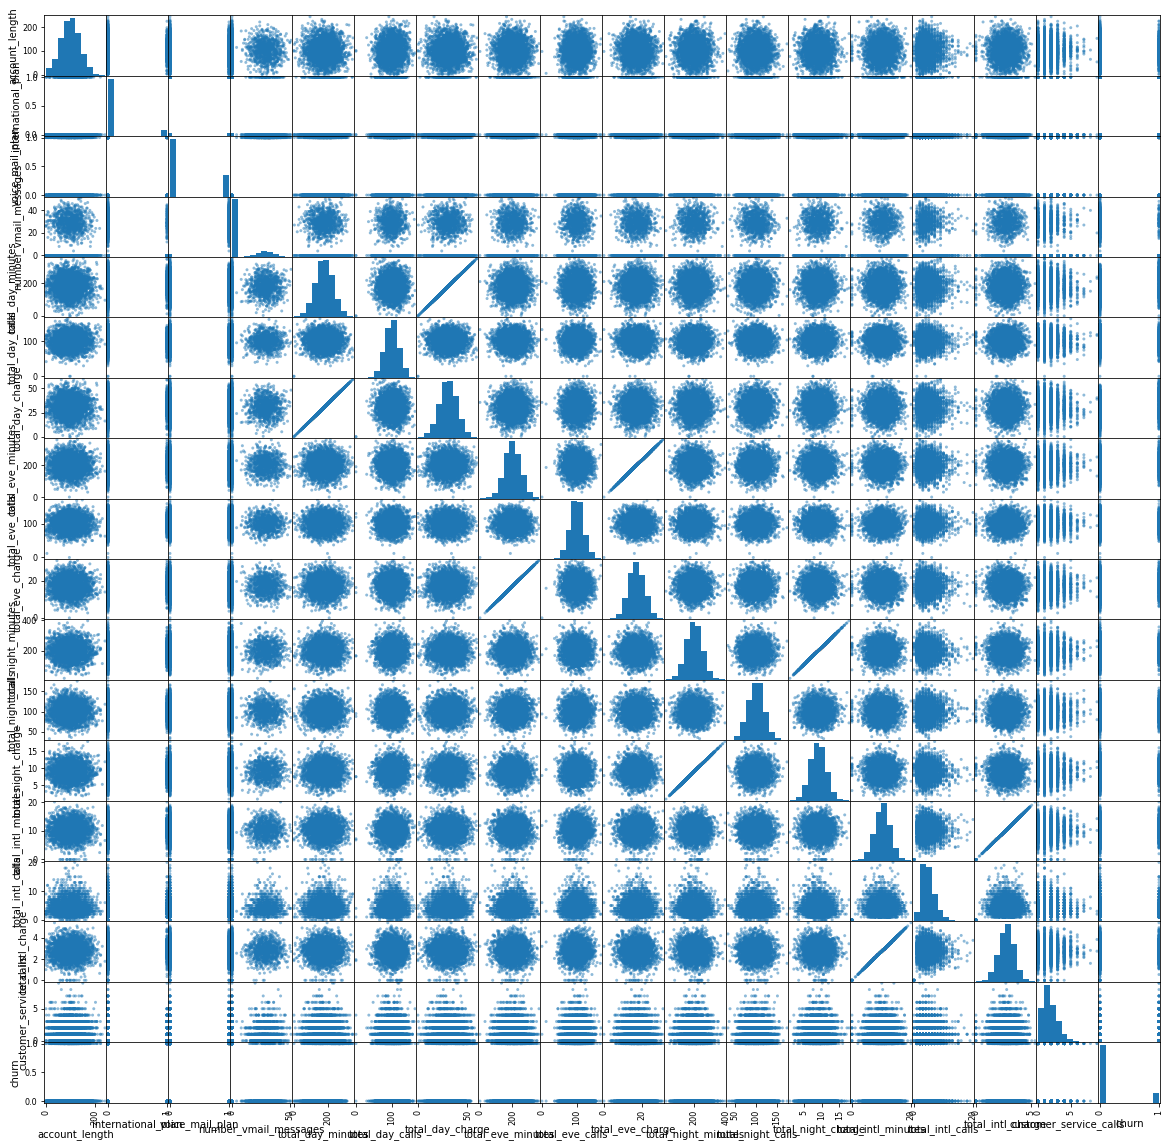

In [69]:
# we plot a scatter matrix to inspect distributions of predictors

pd.plotting.scatter_matrix(df, figsize=[20,20]);
plt.show()

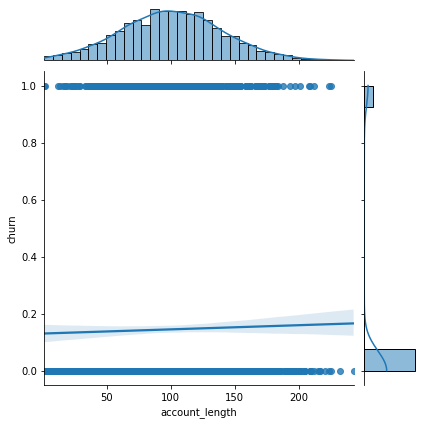

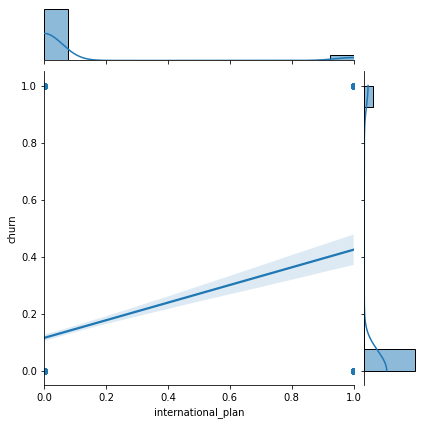

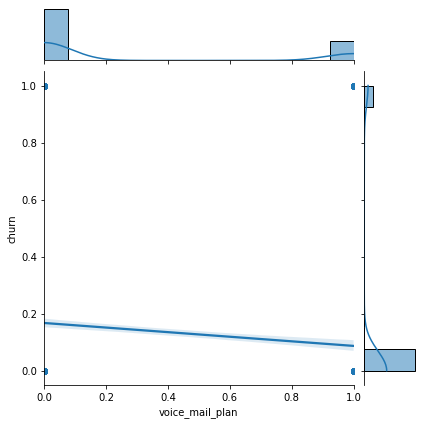

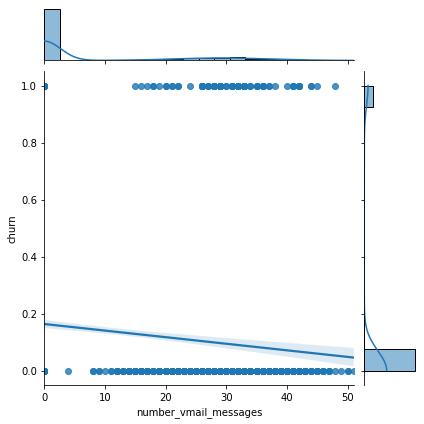

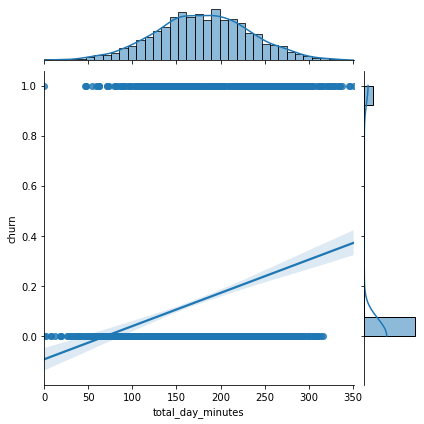

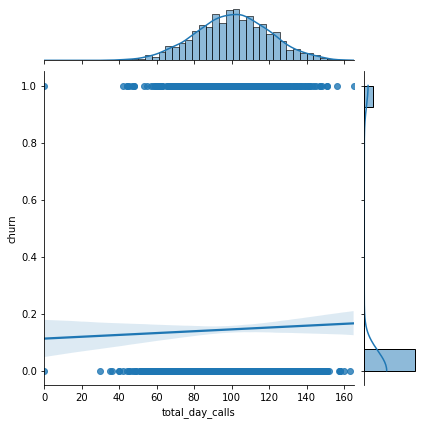

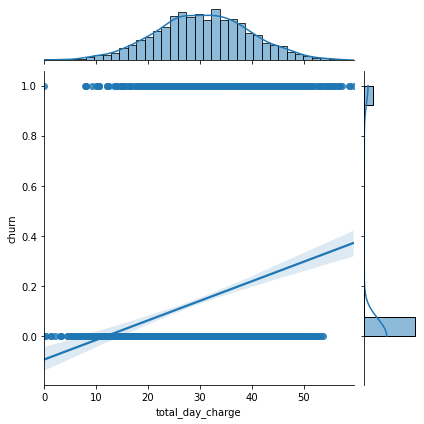

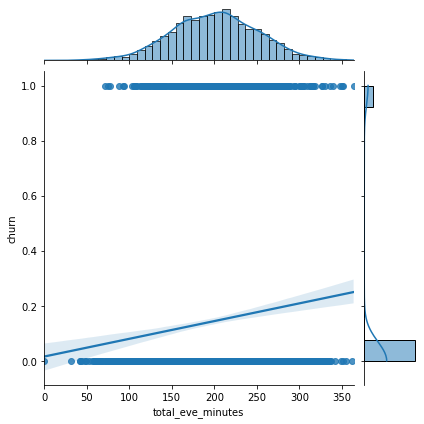

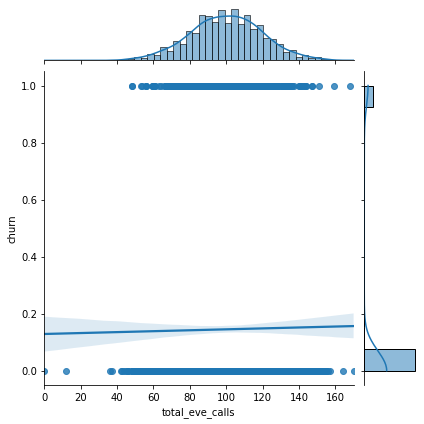

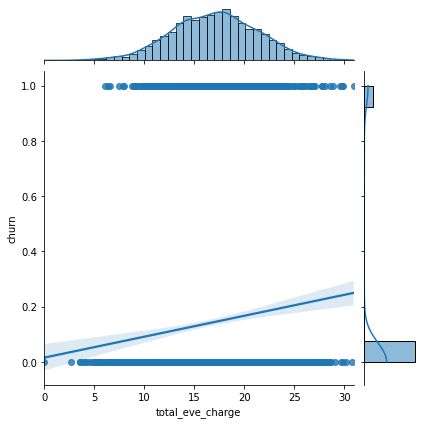

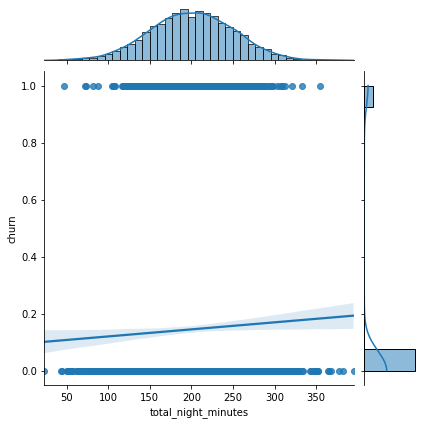

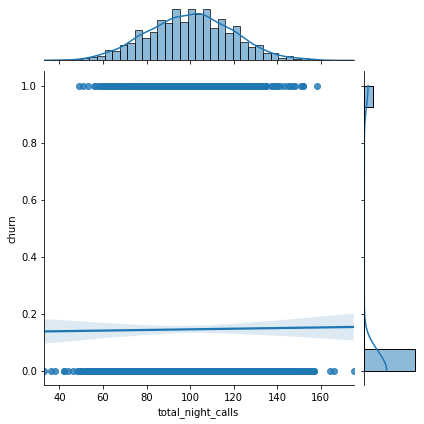

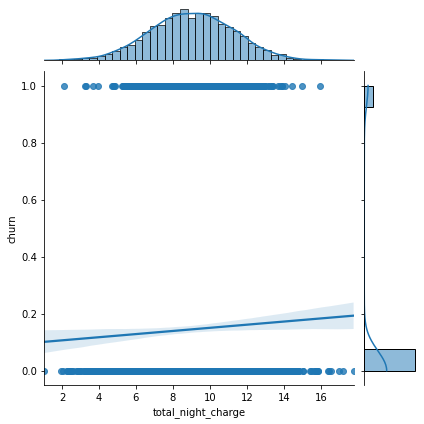

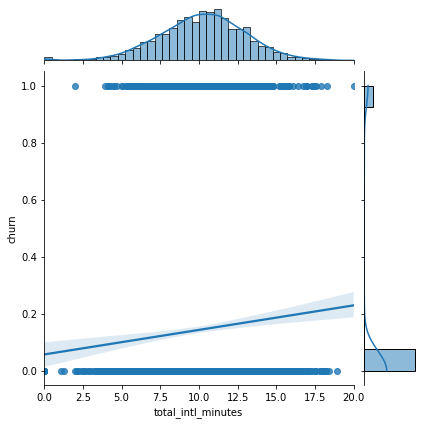

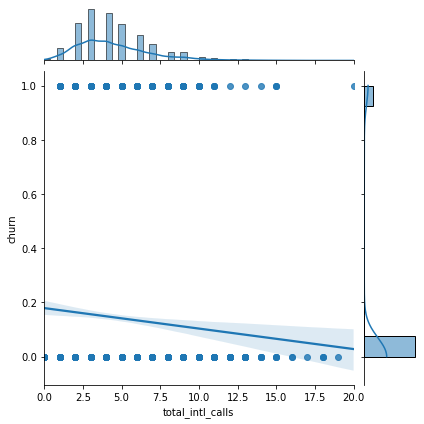

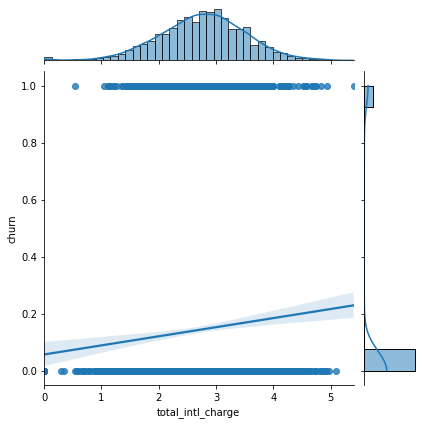

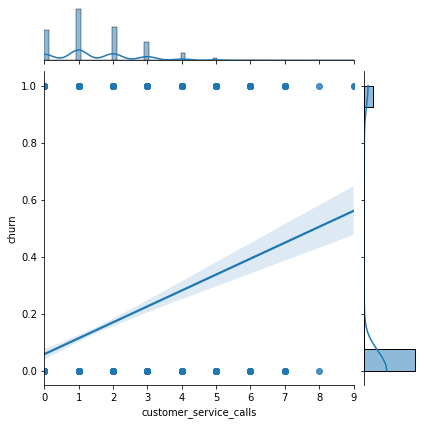

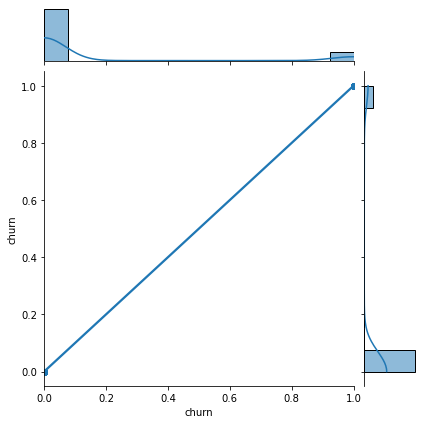

In [70]:
for col in df.columns[1:]:
    sns.jointplot(x=col, y='churn', data=df, kind='reg');

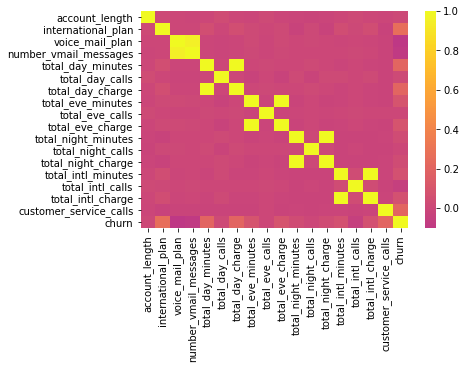

In [71]:
# Heatmap for correlation values
import seaborn as sns
sns.heatmap(df.corr(), cmap='plasma', center=0);

There appears to be be some heavy multicollinearity between some factors. Let's identify which ones are causing an issue

In [72]:
# Displays if correlation coefficient values is greater than 0.75
df.corr()
abs(df.corr()) > 0.75

# Finds which column pairs have a CC values > 0.75
df_mc = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

df_mc['pairs'] = list(zip(df_mc.level_0, df_mc.level_1))

df_mc.set_index(['pairs'], inplace = True)

df_mc.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
df_mc.columns = ['cc']

df_mc.drop_duplicates(inplace=True)

df_mc[(df_mc.cc>.75) & (df_mc.cc<1)]

,cc
pairs,
"(total_day_minutes, total_day_charge)",1.000000
"(total_eve_minutes, total_eve_charge)",1.000000
"(total_night_charge, total_night_minutes)",0.999999
"(total_intl_charge, total_intl_minutes)",0.999993
"(number_vmail_messages, voice_mail_plan)",0.956927


* Let's get rid of the factors related to minutes and keep the charge factors. Price is probably more important to our overall analysis
* We will also remove number_vmail_messages as the more important factor is that they have a voicemail plan.

In [73]:
# Dropping total_day_minutes, total_eve_minutes, total_night_minutes, total_intl_minutes, number_vmail_messages

df.drop(['total_day_minutes','total_eve_minutes','total_night_minutes','total_intl_minutes','number_vmail_messages'], axis = 1, inplace=True)

In [74]:
df.head()

,state,account_length,international_plan,voice_mail_plan,total_day_calls,total_day_charge,total_eve_calls,total_eve_charge,total_night_calls,total_night_charge,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,0,1,110,45.07,99,16.78,91,11.01,3,2.70,1,0
1,OH,107,0,1,123,27.47,103,16.62,103,11.45,3,3.70,1,0
2,NJ,137,0,0,114,41.38,110,10.30,104,7.32,5,3.29,0,0
3,OH,84,1,0,71,50.90,88,5.26,89,8.86,7,1.78,2,0
4,OK,75,1,0,113,28.34,122,12.61,121,8.41,3,2.73,3,0


## Modeling

Now that we have explored the cleaned data, we can finally move on to create models to properly see the effects of each of the factors on telecom customer churning.

### Logistic Regression (Baseline)

In [75]:
df_dummy = pd.get_dummies(df)
df_dummy.head()

,account_length,international_plan,voice_mail_plan,total_day_calls,total_day_charge,total_eve_calls,total_eve_charge,total_night_calls,total_night_charge,total_intl_calls,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,128,0,1,110,45.07,99,16.78,91,11.01,3,...,0,0,0,0,0,0,0,0,0,0
1,107,0,1,123,27.47,103,16.62,103,11.45,3,...,0,0,0,0,0,0,0,0,0,0
2,137,0,0,114,41.38,110,10.30,104,7.32,5,...,0,0,0,0,0,0,0,0,0,0
3,84,1,0,71,50.90,88,5.26,89,8.86,7,...,0,0,0,0,0,0,0,0,0,0
4,75,1,0,113,28.34,122,12.61,121,8.41,3,...,0,0,0,0,0,0,0,0,0,0


In [76]:
# Create X,y and train/test
X = df_dummy.drop(columns=['churn'], axis=1)
y = df_dummy['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 10)

In [77]:
# initial regression
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = logreg.fit(X_train, y_train)

In [78]:
# Prediction
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

In [79]:
display(model_log.score(X_train, y_train))
display(model_log.score(X_test, y_test))

0.8690922730682671

0.8605697151424287

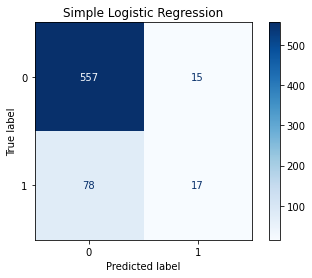

In [80]:
# we visualize our confusion matrix, taking note of False Negatives above all else. 

plot_confusion_matrix(model_log, X_test, y_test,cmap=plt.cm.Blues)
plt.title('Simple Logistic Regression')
plt.show()

In [81]:
# we compute our validation metric, recall

print('Training Precision: ', precision_score(y_train, y_hat_train))
print('Testing Precision: ', precision_score(y_test, y_hat_test))
print('\n\n')

print('Training Recall: ', recall_score(y_train, y_hat_train))
print('Testing Recall: ', recall_score(y_test, y_hat_test))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train, y_hat_train))
print('Testing F1-Score: ', f1_score(y_test, y_hat_test))

Training Precision:  0.6211180124223602
Testing Precision:  0.53125



Training Recall:  0.25773195876288657
Testing Recall:  0.17894736842105263



Training Accuracy:  0.8690922730682671
Testing Accuracy:  0.8605697151424287



Training F1-Score:  0.36429872495446264
Testing F1-Score:  0.2677165354330709


Conclusions on Simple Logistic Regression
* With a score less than 85%, this model can't be said to perform well.
* Furthermore, our testing score is sufficiently distant from our training score that our model is not consistent.

### Random Forest

In [82]:
# we establish a fresh dataframe for our random forest

df_rf = pd.get_dummies(df)

In [83]:
# Create X,y and train/test
X = df_dummy.drop(columns=['churn'], axis=1)
y = df_dummy['churn']

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.25, random_state=10)

In [84]:
# we establish our Random Forest and a parameter grid

tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier()

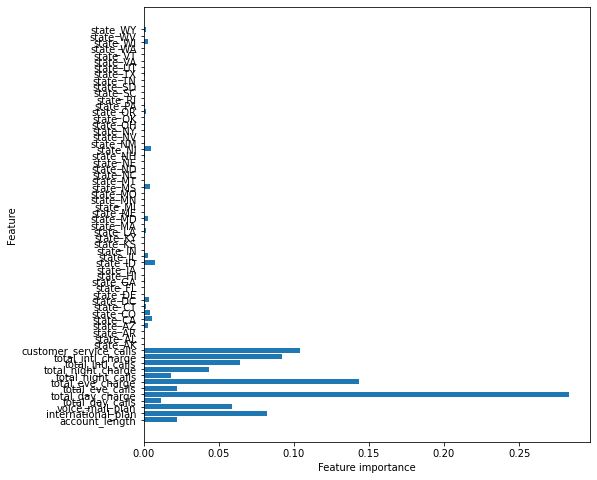

In [85]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(tree_clf)

In [86]:
# Test set predictions
pred = tree_clf.predict(X_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print("Testing Accuracy for Decision Tree Classifier: {:.4}%".format(accuracy_score(y_test, pred) * 100))

[[681  34]
 [ 31  88]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       715
           1       0.72      0.74      0.73       119

    accuracy                           0.92       834
   macro avg       0.84      0.85      0.84       834
weighted avg       0.92      0.92      0.92       834

Testing Accuracy for Decision Tree Classifier: 92.21%


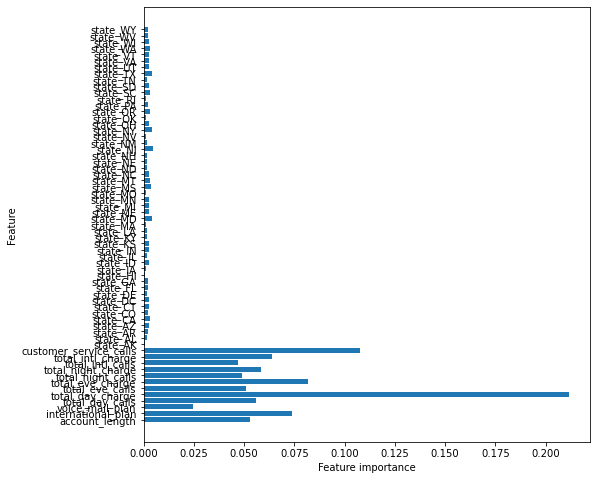

In [87]:
forest = RandomForestClassifier()
forest.fit(X_train, np.ravel(y_train))
plot_feature_importances(forest)

In [88]:
param_grid = {
    'max_depth': [2, 5, 10, 25],
    'min_samples_split': [2, 5, 10, 20]
}

gs_tree = GridSearchCV(forest, param_grid, cv=3)
gs_tree.fit(X_train, np.ravel(y_train))

gs_tree.best_params_

{'max_depth': 25, 'min_samples_split': 5}

In [89]:
forest = RandomForestClassifier(max_depth=5, min_samples_split=2)
forest.fit(X_train, np.ravel(y_train))
preds = forest.predict(X_test)
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))
print("Testing Accuracy for Random Forest Classifier: {:.4}%".format(accuracy_score(y_test, preds) * 100))

[[715   0]
 [119   0]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       715
           1       0.00      0.00      0.00       119

    accuracy                           0.86       834
   macro avg       0.43      0.50      0.46       834
weighted avg       0.73      0.86      0.79       834

Testing Accuracy for Random Forest Classifier: 85.73%


C:\Users\leebr\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### XG Boost

In [90]:
# Instantiate XGBClassifier
xgb = XGBClassifier()

# Fit XGBClassifier
xgb.fit(X_train, np.ravel(y_train))

# Predict on training and test sets
training_preds = xgb.predict(X_train)
test_preds = xgb.predict(X_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 100.0%
Validation accuracy: 96.04%


In [91]:
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

grid_clf = GridSearchCV(xgb, param_grid, scoring='accuracy')
grid_clf.fit(X_train, np.ravel(y_train))

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
test_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 1
n_estimators: 100
subsample: 0.7

Training Accuracy: 98.44%
Validation accuracy: 96.76%


In [92]:
print(confusion_matrix(y_test, test_preds))
print(classification_report(y_test, test_preds))
print("Testing Accuracy for XGBoost: {:.4}%".format(accuracy_score(y_test, test_preds) * 100))

[[712   3]
 [ 24  95]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       715
           1       0.97      0.80      0.88       119

    accuracy                           0.97       834
   macro avg       0.97      0.90      0.93       834
weighted avg       0.97      0.97      0.97       834

Testing Accuracy for XGBoost: 96.76%


### Gradient Boosting